In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate, optimize
import pandas as pd
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_log_error, mean_squared_error
import os
import matplotlib.pylab as plt
import scipy

# loading time series data

url='https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/'
df_confirmed = pd.read_csv(url + 'time_series_covid19_confirmed_global.csv',error_bad_lines=False)  #( time_series_19-covid-Confirmed.csv)
df_confirmed.rename(columns={'Country/Region':'Country'}, inplace=True)

#df = pd.read_csv(url, error_bad_lines=False)
date='4/13/20'
odir='ModelB_without_lockdown_' + date.replace('/','_') + '/'
try:  
    os.mkdir(odir)  
except OSError as error:  
    print('Directory exists: ', odir)

df_confirmed=df_confirmed.groupby(['Country']).sum()
df_confirmed=df_confirmed.drop(columns=['Lat','Long'])
top_affected_countries=df_confirmed.sort_values([date],ascending=False).index[:40].values #20/20

df=df_confirmed.loc[top_affected_countries,:]



#df= pd.read_csv("confirmed-data-top-affected-countries.csv")

'''
import os
date='3/29/20'
odir = date.replace('/','_') + '/'

df= pd.read_csv("../countries-spread-rate/"+odir+"confirmed-data-top-affected-countries.csv")
try:  
    os.mkdir(odir)  
except OSError as error:  
    print(error)
'''    

print('countries to choose from: ', df.index)

# loading population data
df_pop=pd.read_csv("population_by_country_2020.csv")




Directory exists:  ModelB_without_lockdown_4_13_20/
countries to choose from:  Index(['US', 'Spain', 'Italy', 'Germany', 'France', 'United Kingdom', 'China',
       'Iran', 'Turkey', 'Belgium', 'Netherlands', 'Switzerland', 'Canada',
       'Brazil', 'Russia', 'Portugal', 'Austria', 'Israel', 'Sweden',
       'Ireland', 'Korea, South', 'India', 'Peru', 'Ecuador', 'Chile', 'Japan',
       'Poland', 'Romania', 'Norway', 'Denmark', 'Australia', 'Czechia',
       'Pakistan', 'Saudi Arabia', 'Philippines', 'Malaysia', 'Mexico',
       'Indonesia', 'United Arab Emirates', 'Serbia'],
      dtype='object', name='Country')


In [5]:
start_from=np.where(df.columns == '2/15/20')[0][0]
df=df[df.columns[start_from:]]

In [6]:
odir1 = date.replace('/','_') + '/'
initial_fit=pd.read_csv("../countries-spread-rate/"+odir1+"top_countries_confirmed_fit.csv")


In [7]:
initial_fit.head()

,Country,slope(log cases),start day,start date,intersecpt(log cases),MSE fit,total cases,total deaths,total recovered,mortality,mu at 21,temp
0,Denmark,0.158140,47,3/9/20,5.578451,4.521789,6513,285,2403,0.043759,0.085967,-18.053051
1,Japan,0.113315,25,2/16/20,4.100619,4.077537,7370,123,784,0.016689,0.105055,11.951907
2,Pakistan,0.215188,53,3/15/20,4.878213,3.970292,5496,93,1095,0.016921,0.122729,20.615513
3,Serbia,0.199803,54,3/16/20,4.061339,4.007333,4054,85,0,0.020967,0.131979,9.986563
4,Peru,0.160777,54,3/16/20,4.741861,4.454347,9784,216,2642,0.022077,0.143110,19.935974


In [8]:
country='Russia'
vals=initial_fit[initial_fit["Country"]==country].values[0,1:]
vals[0]

0.2228877239454084

In [9]:
# plot settings
from matplotlib import rc
#matplotlib.rc('text.latex', preamble='\\usepackage{txfonts}')


#rc('text', usetex=True)
#rc('font', family='serif')
#rc('font', serif='times')
rc('mathtext', default='sf')
rc("lines", markeredgewidth=1)
rc("lines", linewidth=2)
rc('axes', labelsize=16)  # 24
rc("axes", linewidth=0.5)  # 2)
rc('xtick', labelsize=14)
rc('ytick', labelsize=14)
rc('legend', fontsize=10)  # 16
rc('xtick.major', pad=6)  # 8)
rc('ytick.major', pad=6)  # 8)
rc('xtick.minor', size=5)  # 8)
rc('ytick.minor', size=5)  # 8)

In [10]:
# get time v/s confirmed cases(10-500) and Ti data for a particular country

def get_data(country,l=None):
    #ydata= df[df["Country"]==country].values[0,1:]
    ydata=df.loc[country].values
    ydata = np.array(ydata, dtype=float)
    idx=np.where(ydata>=50)[0][0]
    idx2= np.where(ydata>1)[0][0]
    #ydata=ydata[idx:]
    
    #idx1= np.where(ydata>=1000)[0][0]
    #ydata=ydata[:idx1]
    
    if l!=None:
        ydata = ydata[:l]
    max_days=len(ydata)
    xdata= np.arange(max_days)
    return xdata,ydata, idx


In [20]:
# SEIIRR Model Parameter Estimation
def seiirr_ivp(x,y,p,beta,Td,Tr,Tl,N):
    S,E,Iu,Id,Rd,Ru = y
    sigma = 1/Tl
    Sd = -beta * (Id + Iu) * S/N
    Ed = beta * (Id + Iu) * S/N - sigma * E
    Iud = (1-p) * sigma * E - Iu/Tr
    Idd = p * sigma * E - Id/Td
    Rdd = Id/Td
    Rud = Iu/Tr
    return Sd, Ed, Iud, Idd, Rdd, Rud

def eval_model_seiirr(params,xdata,ydata,population,t0,min_routine=True): # params: parameters to optimize over: p

    p,beta = params
    N = population
    max_days=len(ydata)
    #Ti=1
    sigma= 1./Tl
    gammaD = 1./Td 
    gammaR= 1./Tr
    
    vals=initial_fit[initial_fit["Country"]==country].values[0,1:]
    lam, rd0=vals[0],np.exp(vals[3])
    Rd0=rd0#*np.exp(lam*t0)
    #Rd0 = rd0

    Id0= lam/gammaD * Rd0
    E0 = (gammaD+lam)*Id0/(p*sigma)
    Iu0 = (1-p)*sigma*E0/(gammaR + lam)
    Ru0 = gammaR/lam *Iu0
    S0 = N -(sigma+lam)/lam * E0
    '''
    E0 = (Rd0 * (Ti + Td) * Tl) / (p * Ti**2)
    Id0 = Rd0 * Td / Ti
    Iu0 = Rd0 * (1/p-1) * (Ti + Td)/(Ti + Tr) * Tr/Tl
    Ru0 = Rd0 * (1/p-1) * (Ti + Td)/(Ti + Tr)
    S0 = N - (Rd0 + E0 + Id0 + Iu0 + Ru0 )
    '''
    #Ti=10
   # beta=(lam+sigma)*(lam+gammaD)*(lam+gammaR)/(sigma*(lam+gammaD-p*(gammaD-gammaR)))
    if min_routine == True:
        sol = integrate.solve_ivp(seiirr_ivp, [t0, max_days+1], [S0, E0, Iu0, Id0, Rd0, Ru0], args=(p,beta,Td,Tr,Tl,N),t_eval=np.arange(t0,max_days),method='RK45')
        #optim_days = min(100, max_days)  # Days to optimise for
        #weights = 1 / np.arange(1, optim_days+1)[::-1]  
        msle_cases = mean_squared_log_error(ydata[t0:], (sol.y[4,:])) 
        return msle_cases
    else:
        max_days=100
        sol = integrate.solve_ivp(seiirr_ivp, [t0, max_days], [S0, E0, Iu0, Id0, Rd0, Ru0], args=(p,beta,Td,Tr,Tl,N),t_eval=np.arange(t0,max_days),method='RK45')
        return sol
    
import itertools
marker = itertools.cycle(( '*', 'o', '*')) 
no_bounds=(1e-5,1)
def fit_country_seiirr(country, population,bounds=no_bounds,l=14):
    N = population
    l=None
    xdata,ydata,t0=get_data(country,l)
    #print(t0)
    res_const = minimize(eval_model_seiirr,[0.1,0.5], bounds=bounds,args=(xdata,ydata, population,t0),method='L-BFGS-B') ## numbers are initial guess
    
    msle_cases=eval_model_seiirr(res_const.x,xdata,ydata,population,t0)
    plt.figure(figsize=(10,7))
    p,beta=res_const.x
    sigma= 1./Tl
    gammaD = 1./Td
    gammaR= 1./Tr
    vals=initial_fit[initial_fit["Country"]==country].values[0,1:]
    lam, intercept=vals[0],vals[3]
    
   # beta=(lam+sigma)*(lam+gammaD)*(lam+gammaR)/(sigma*(lam+gammaD-p*(gammaD-gammaR)))

    coeff=[1,(gammaD + gammaR + sigma), gammaD*gammaR + sigma*(gammaD+gammaR-beta), p*beta*sigma*(gammaD-gammaR) + sigma*gammaD*(gammaR-beta) ]
    coeff=np.array(coeff)
    lambdas=np.roots(coeff)
   # lambdas=lambdas[lambdas>0]
    R0 = beta*(p* Td + (1-p)*Tr)
    R0obs = beta*p*Td
    la = country + ": p = %.6f, "%p +r" $\beta$ =  %3.2f, " %beta + 'MSLE = %.3f \n '%msle_cases + '$R_0$ = %.2f, '%R0 + '$R_0^o$ = %.2f, '%R0obs + '$\lambda^{est}$='+str(lambdas) 
    #print(Ti)
    sol= eval_model_seiirr(res_const.x,xdata,ydata,population,t0,min_routine=False)

    xdata,ydata,t0=get_data(country)
    ini_fit= np.exp(lam*(xdata-t0)+intercept)
    plt.plot(xdata,ydata,marker=next(marker),linestyle='',label=country,markersize=10)
    plt.plot(xdata,ini_fit,'--',label='initial_fit %.3f'%lam)
    
    plt.plot(sol.t,sol.y[4,:],label = la ,linewidth=2)
    plt.plot(sol.t,sol.y[2,:],label='I_u')
    plt.plot(sol.t,sol.y[3,:],label='I_d')
    plt.axhline(population,linestyle='dashed',label='population')
    prefix=''
    if l!=None :
        plt.axvline(l, linestyle='dashed', color='gray')
        prefix=str(l) + '_'

    plt.yscale('log')
    plt.xlabel('Days')
    plt.ylabel('Confirmed cases fit with $R_d$')
    plt.grid()
    plt.tight_layout()
    plt.legend(fontsize=14)
    #prefix='full_'
    print(country, ': Estimated \lambda =',lambdas)
    plt.savefig(odir+prefix+country+'.png')
    return sol


Spain : Estimated \lambda = [-10.0000632   -0.57062026   0.30401679]
Germany : Estimated \lambda = [-10.00002326  -0.53346232   0.26681891]
France : Estimated \lambda = [-10.00002354  -0.51539833   0.2487552 ]
Belgium : Estimated \lambda = [-10.00003551  -0.48420693   0.21757578]
Switzerland : Estimated \lambda = [-10.00004451  -0.53093843   0.26431627]
Netherlands : Estimated \lambda = [-10.00001938  -0.48530896   0.21866167]
Canada : Estimated \lambda = [-10.00001106  -0.50275829   0.23610268]


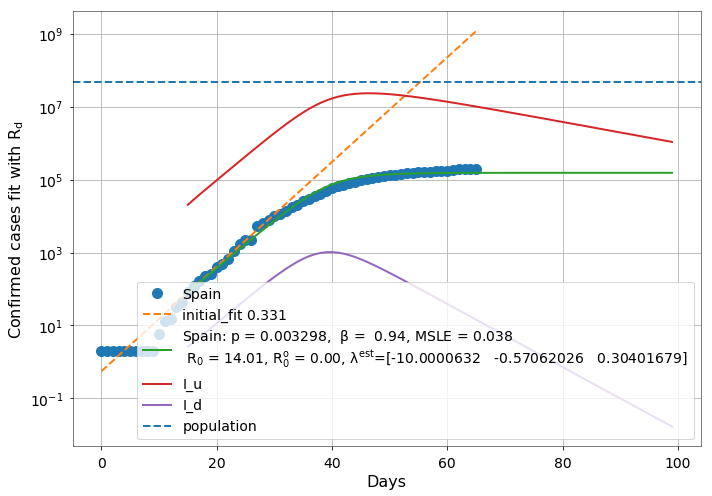

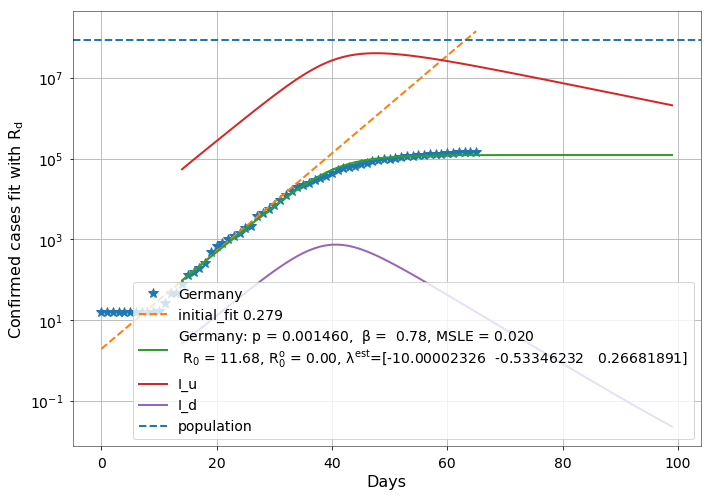

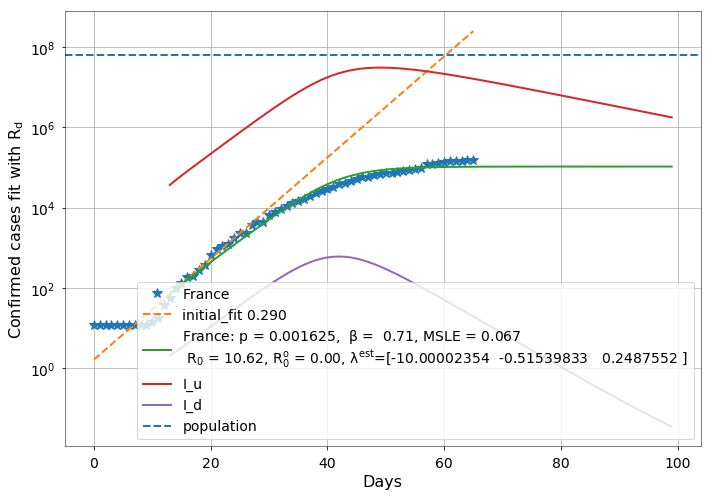

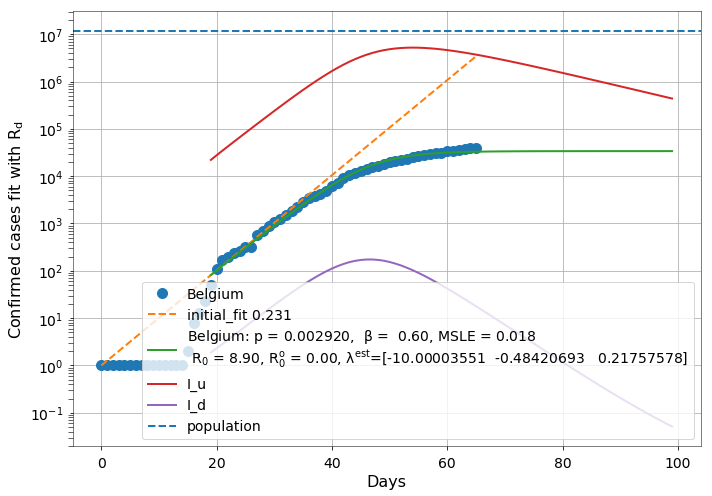

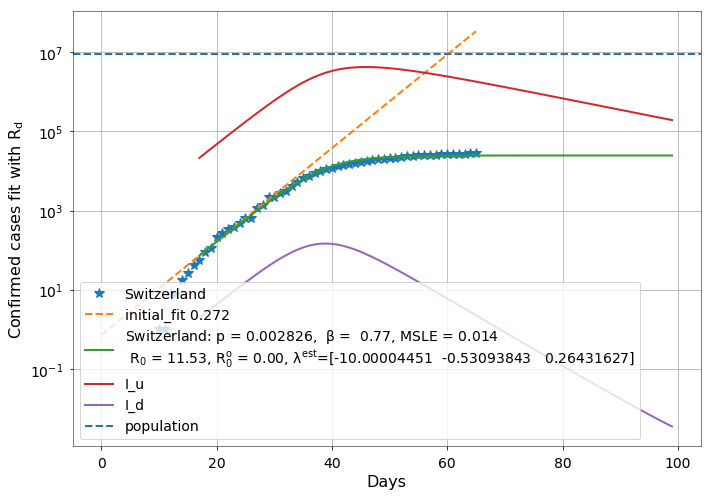

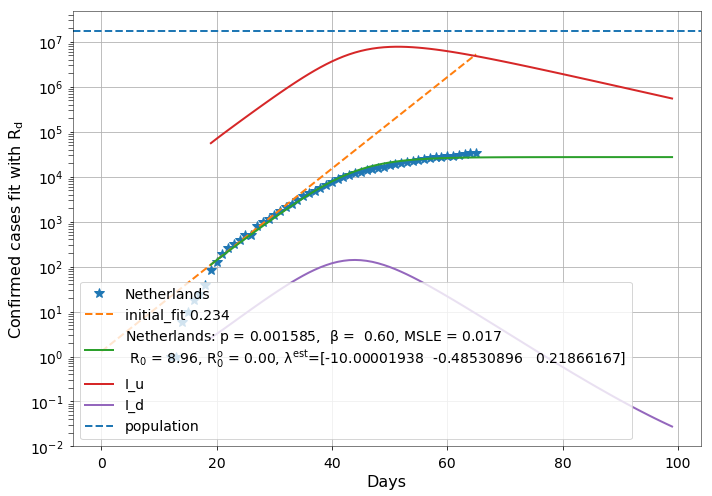

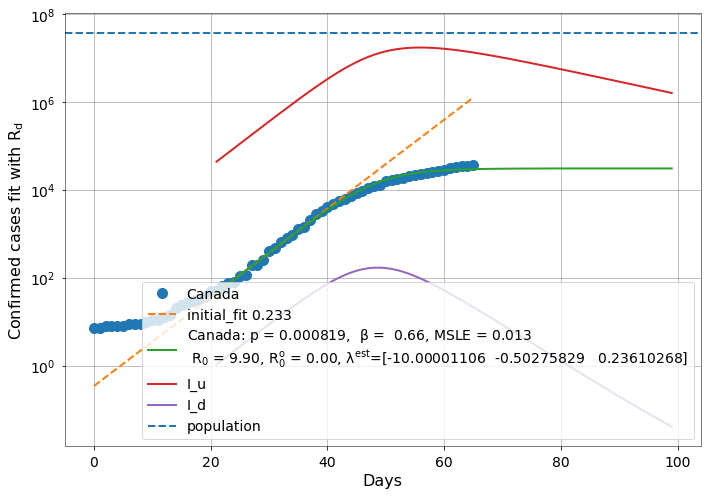

In [27]:
## SEIIRR for Spain and Germany
bounds1=[(0.00001,1.),(0.,2.5)] # ((pmin,pmax),(beta_min, beta_max))
#bounds1=((0.0001,.01),(0.6,.9),(1,10))

Tl = 5
Tr = 15
Td = 1

country='Spain'
population=df_pop[df_pop["Country (or dependency)"]=='Spain']["Population (2020)"].values[0]
sol = fit_country_seiirr(country,population,bounds=bounds1)
#print(population)
country='Germany'
population=df_pop[df_pop["Country (or dependency)"]=='Germany']["Population (2020)"].values[0]
sol1 = fit_country_seiirr(country,population,bounds=bounds1)
country='France'
population=df_pop[df_pop["Country (or dependency)"]=='France']["Population (2020)"].values[0]
sol1 = fit_country_seiirr(country,population,bounds=bounds1)

country='Belgium'
population=df_pop[df_pop["Country (or dependency)"]=='Belgium']["Population (2020)"].values[0]
sol1 = fit_country_seiirr(country,population,bounds=bounds1)
country='Switzerland'
population=df_pop[df_pop["Country (or dependency)"]=='Switzerland']["Population (2020)"].values[0]
sol1 = fit_country_seiirr(country,population,bounds=bounds1)
country='Netherlands'
population=df_pop[df_pop["Country (or dependency)"]=='Netherlands']["Population (2020)"].values[0]
sol1 = fit_country_seiirr(country,population,bounds=bounds1)
country='Canada'
population=df_pop[df_pop["Country (or dependency)"]=='Canada']["Population (2020)"].values[0]
sol1 = fit_country_seiirr(country,population,bounds=bounds1)
#plt.savefig('p_beta_Spain_Germany_extrapolate.png')
#plt.savefig('p_beta_Spain_Germany.png')


Iran : Estimated \lambda = [-10.00001163  -0.58004565   0.31339061]


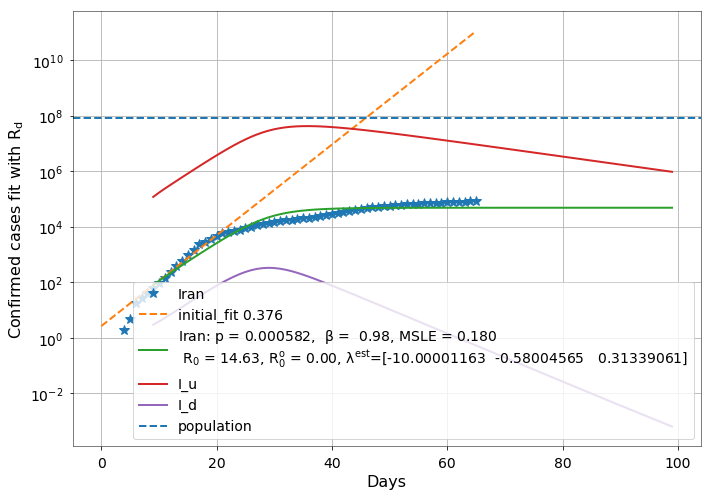

In [28]:

country='Iran'
population=df_pop[df_pop["Country (or dependency)"]=='Iran']["Population (2020)"].values[0]
_ = fit_country_seiirr(country,population,bounds=bounds1)





United Kingdom : Estimated \lambda = [-10.00001977  -0.49465377   0.22800688]
US : Estimated \lambda = [-10.00003145  -0.51739477   0.25075956]


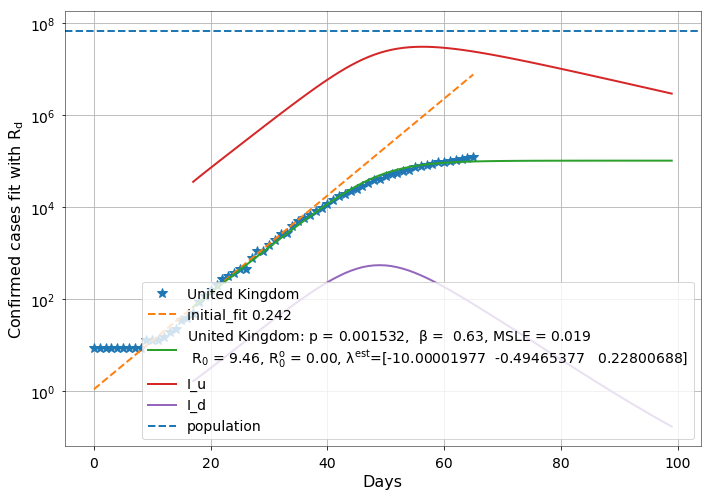

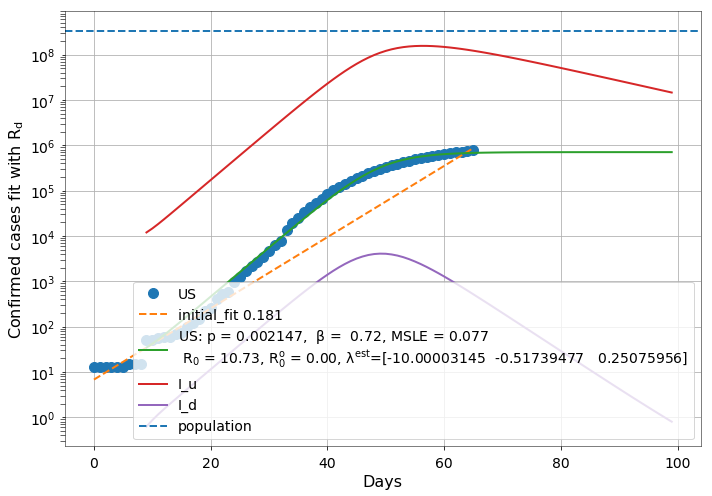

In [29]:
country='United Kingdom'
population=df_pop[df_pop["Country (or dependency)"]=='United Kingdom']["Population (2020)"].values[0]
_ = fit_country_seiirr(country,population,bounds=bounds1)
country='US'
population=df_pop[df_pop["Country (or dependency)"]=='United States']["Population (2020)"].values[0]
_ = fit_country_seiirr(country,population,bounds=bounds1)

India : Estimated \lambda = [-10.00000019  -0.43697396   0.17030749]
India : Estimated \lambda = [-10.00000812  -0.4228913    0.15623275]


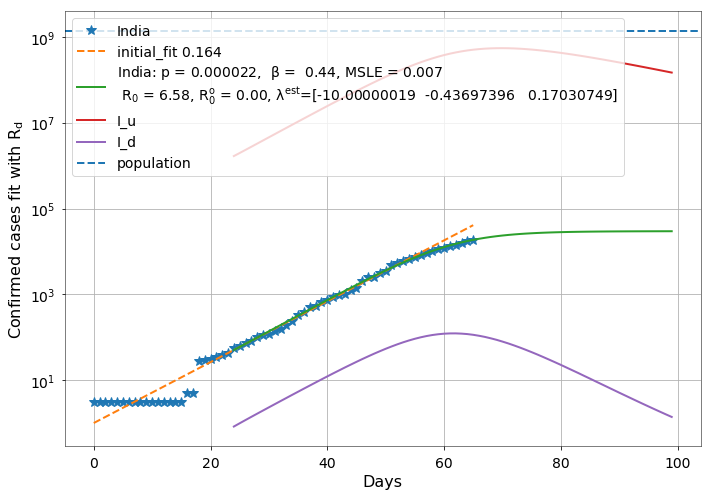

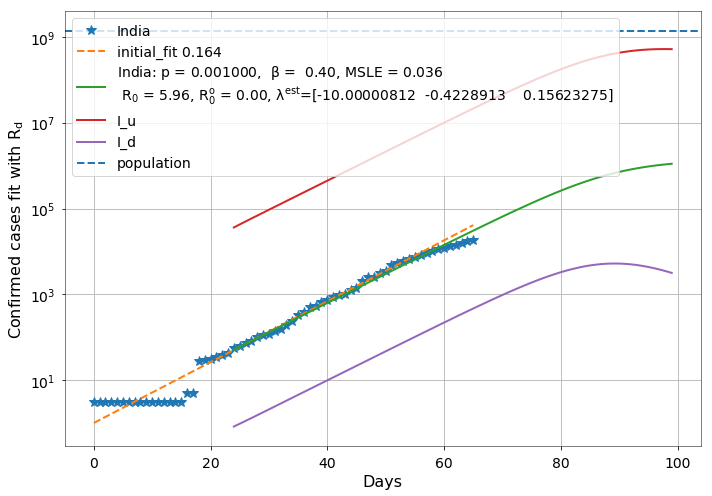

In [34]:
bounds=[(0.000001,1e-2),(0.,2.5)]
country='India'
population=df_pop[df_pop["Country (or dependency)"]=='India']["Population (2020)"].values[0]
_ = fit_country_seiirr(country,population,bounds=bounds)
bounds=[(0.001,1e-2),(0.,2.5)]
country='India'
population=df_pop[df_pop["Country (or dependency)"]=='India']["Population (2020)"].values[0]
_ = fit_country_seiirr(country,population,bounds=bounds)